# Historical temperatures in Lyon

In [132]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import calendar
import warnings
from io import StringIO
import matplotlib.dates as mdates
%matplotlib inline

plt.style.use('seaborn')
pd.plotting.register_matplotlib_converters()

# figure parameters
fs = (20, 12)
matplotlib.rcParams.update({
    'legend.fontsize': 20,
    'legend.title_fontsize': 24,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'axes.labelsize': 22,
    'axes.titlesize': 22,
    'font.family': 'ubuntu'})

In [130]:
# import matplotlib.font_manager
# matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

## Temperature data preparation

### df1: 1743-2013 temperatures

Historical monthly temperature data of Lyon from [http://berkeleyearth.lbl.gov](http://berkeleyearth.lbl.gov/auto/Local/TAVG/Text/45.81N-5.77E-TAVG-Trend.txt) 

In [2]:
with open('45.81N-5.77E-TAVG-Trend.txt') as f:
    content = f.read()

In [3]:
content = content.replace(',', ' ')
content = content.replace('%', ' ')
sio = StringIO(content)

In [4]:
df1 = pd.read_csv(sio, delim_whitespace=True, skiprows=66).reset_index().iloc[:, 0:5]
df1.head(2)

,index,Year,Month,Anomaly,Unc.
0,0,1743,11,0.748,1.825
1,1,1743,12,NaN,NaN


In [5]:
df1.drop('index', axis='columns', inplace=True)

Mean absolute temperatures :

In [6]:
mat = pd.DataFrame({
    'Month': np.arange(1, 13),
    'T_MAT': [-0.22, 1.3, 4.49, 7.75, 12.19, 15.62, 17.88, 17.10, 14.12, 9.10, 4.11, 0.82],
    'Unc_MAT': [1.02, 0.70, 0.59, 0.78, 0.82, 0.83, 0.83, 0.69, 0.55, 0.63, 0.81, 1.02]})

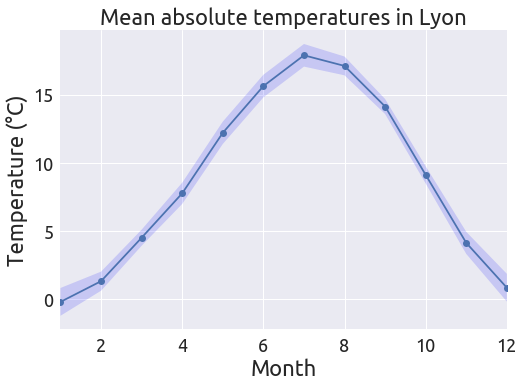

In [133]:
ax = mat.plot(style='o-', x='Month', y='T_MAT', legend=False);
ax.fill_between(mat.Month, mat.T_MAT-mat.Unc_MAT, mat.T_MAT+mat.Unc_MAT,alpha=0.15, facecolor='b');
ax.set_ylabel('Temperature (°C)');
ax.set_title('Mean absolute temperatures in Lyon');

In [8]:
df1 = pd.merge(df1, mat, on='Month', how='left')

In [9]:
df1.head(2)

,Year,Month,Anomaly,Unc.,T_MAT,Unc_MAT
0,1743,11,0.748,1.825,4.11,0.81
1,1743,12,NaN,NaN,0.82,1.02


In [10]:
df1['temp'] = df1.T_MAT + df1.Anomaly
df1['unc'] = df1['Unc.']  #df1.Unc_MAT + df1['Unc.']

In [11]:
df1.drop(['Anomaly', 'Unc.', 'T_MAT', 'Unc_MAT'], axis='columns', inplace=True)
df1.rename(columns={'Year': 'year', 'Month': 'month'}, inplace=True)
df1.head(2)

,year,month,temp,unc
0,1743,11,4.858,1.825
1,1743,12,NaN,NaN


In [12]:
df1['day'] = 1
df1["date"] = pd.to_datetime(df1[['year', 'month', 'day']])
df1.set_index("date", inplace=True)
df1.drop(['year', 'month', 'day'], axis=1, inplace=True)
df1.head(2)

,temp,unc
date,,
1743-11-01,4.858,1.825
1743-12-01,NaN,NaN


In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3239 entries, 1743-11-01 to 2013-09-01
Data columns (total 2 columns):
temp    3166 non-null float64
unc     3166 non-null float64
dtypes: float64(2)
memory usage: 75.9 KB


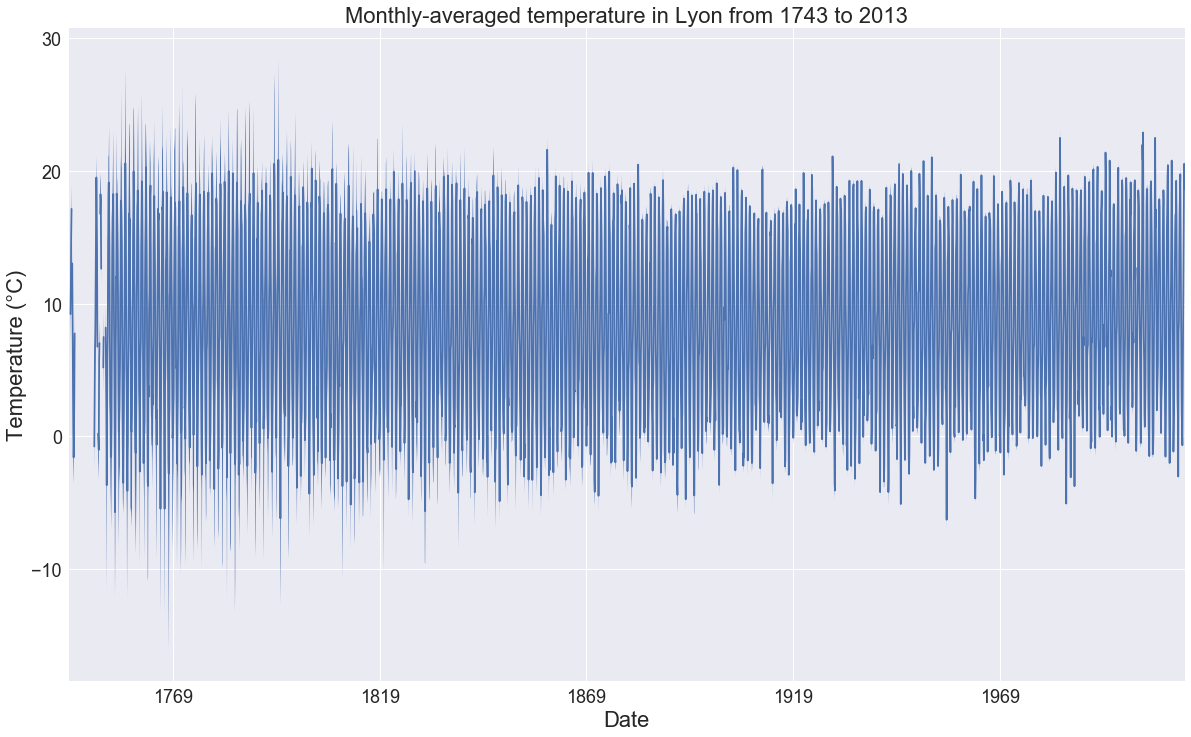

In [14]:
ax = df1.temp.plot(figsize=fs);
ax.fill_between(df1.index, df1.temp - df1.unc, df1.temp + df1.unc)
ax.set_xlabel('Date');
ax.set_ylabel('Temperature (°C)');
ax.set_title('Monthly-averaged temperature in Lyon from 1743 to 2013');

### df2: 1901-2016 temperatures

Historical monthly temperature data of Lyon from [worldbank](https://climateknowledgeportal.worldbank.org/download-data) 

In [15]:
df2 = pd.read_csv('tas_1901_2016_4.942764_45.724942.csv', usecols=['Temperature - (Celsius)', ' Year', ' Statistics'])
df2.rename(columns={'Temperature - (Celsius)': 'temp', ' Year': 'year', ' Statistics': 'month'}, inplace=True)
df2.month = df2.month.map(lambda s: s.strip().split(' ')[0])
df2.head(2)

,temp,year,month
0,0.9,1901,Jan
1,-1.5,1901,Feb


In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1392 entries, 0 to 1391
Data columns (total 3 columns):
temp     1392 non-null float64
year     1392 non-null int64
month    1392 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 32.8+ KB


Let's convert the `year` and `month` attributes to datetime.

%Y Year with century as a decimal number (e.g. 2013)  
%b Month as locale’s abbreviated name (e.g. Sep)  
ref: http://strftime.org/

In [17]:
df2['date'] = pd.to_datetime(df2['year'].astype(str) + df2['month'], format='%Y%b')
df2.set_index('date', inplace=True)
df2.head(2)

,temp,year,month
date,,,
1901-01-01,0.9,1901,Jan
1901-02-01,-1.5,1901,Feb


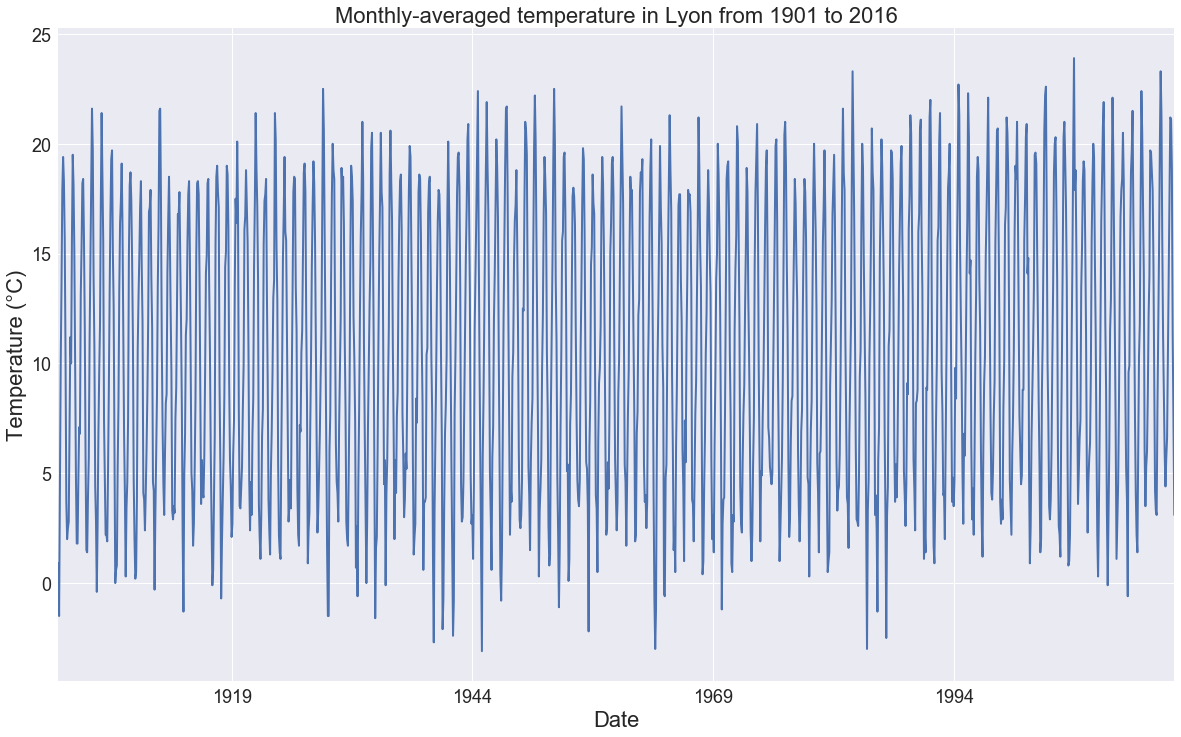

In [18]:
ax = df2.temp.plot(linewidth=2, figsize=fs);
ax.set_xlabel('Date');
ax.set_ylabel('Temperature (°C)');
ax.set_title('Monthly-averaged temperature in Lyon from 1901 to 2016');

### df3: 2009-2019 temperatures

We download the historical daily temperature data of Lyon from [historique-meteo.net](https://www.historique-meteo.net/france/rh-ne-alpes/lyon/) 

In [19]:
df3 = pd.read_csv('export-lyon.csv', skiprows=3, usecols=['DATE', 'TEMPERATURE_MORNING_C', 'TEMPERATURE_NOON_C', 'TEMPERATURE_EVENING_C'])
df3.rename(columns={'DATE': 'date'},inplace=True)
df3.date = pd.to_datetime(df3.date)
df3.set_index('date', inplace=True)
df3.head(2)

,TEMPERATURE_MORNING_C,TEMPERATURE_NOON_C,TEMPERATURE_EVENING_C
date,,,
2009-01-01,0,5,0
2009-01-02,-3,3,-2


In [20]:
df3['temp'] = 0.4 * df3['TEMPERATURE_MORNING_C'] + 0.2 * df3['TEMPERATURE_NOON_C'] + 0.4 * df3['TEMPERATURE_EVENING_C']
df3.drop(['TEMPERATURE_MORNING_C', 'TEMPERATURE_NOON_C', 'TEMPERATURE_EVENING_C'], axis='columns', inplace=True)

df3 = df3.resample('MS').mean()

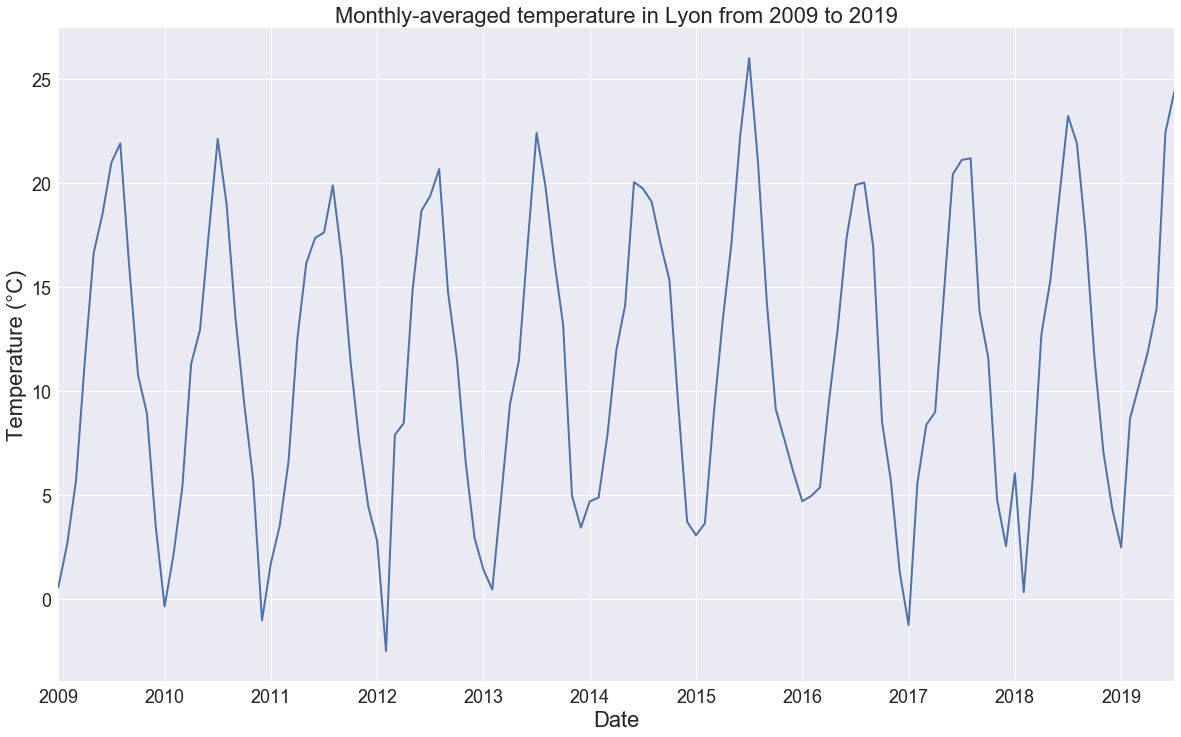

In [21]:
ax = df3.temp.plot(linewidth=2, figsize=fs);
ax.set_xlabel('Date');
ax.set_ylabel('Temperature (°C)');
ax.set_title('Monthly-averaged temperature in Lyon from 2009 to 2019');

### df1 vs df2 temperatures

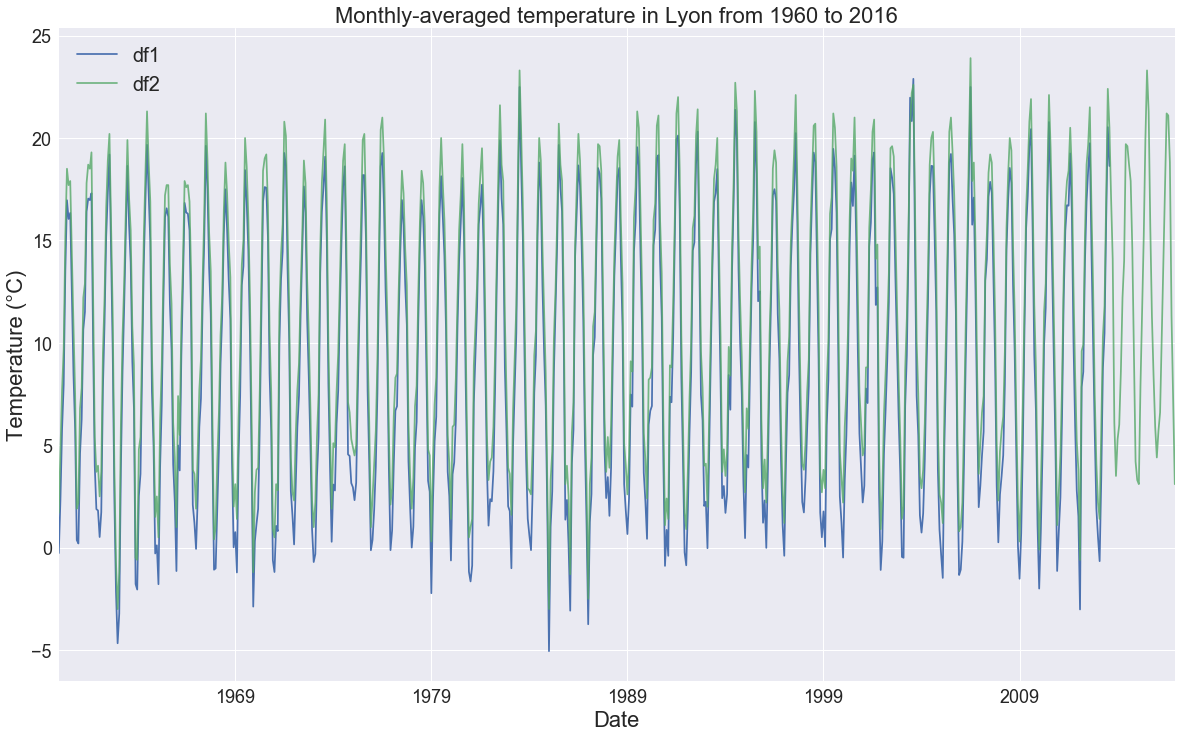

In [22]:
start = '1960'
end = '2016'
ax = df1.temp[start:end].plot(figsize=fs, label='df1');
df2[start:end].temp.plot(ax=ax, figsize=fs, alpha=0.8, label='df2');
ax.set_xlabel('Date');
ax.set_ylabel('Temperature (°C)');
ax.set_title(f'Monthly-averaged temperature in Lyon from {start} to {end}');
ax.legend();

In [23]:
(df2.temp-df1.temp).mean()

1.7388500392921877

In [24]:
(df2.temp-df1.temp).std()

0.40346878946237563

In [25]:
df1.temp += 1.7388500392921877

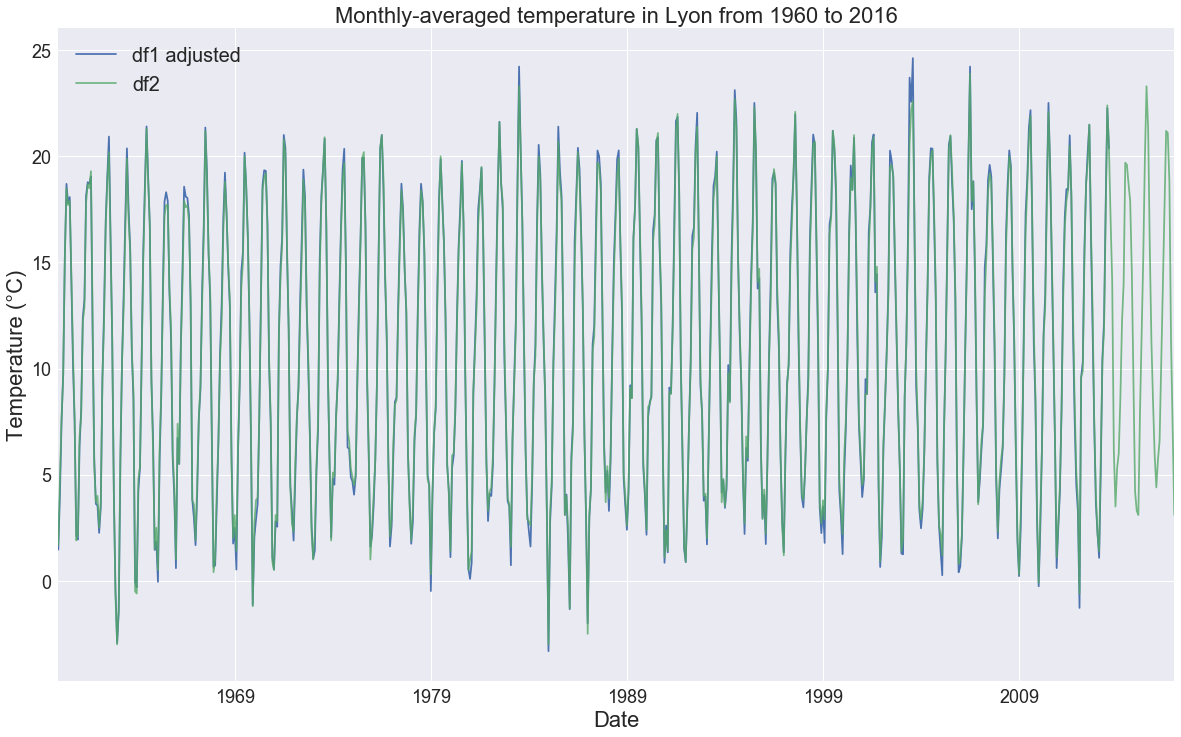

In [26]:
start = '1960'
end = '2016'
ax = df1.temp[start:end].plot(figsize=fs, label='df1 adjusted');
df2[start:end].temp.plot(ax=ax, figsize=fs, alpha=0.8, label='df2');
ax.set_xlabel('Date');
ax.set_ylabel('Temperature (°C)');
ax.set_title(f'Monthly-averaged temperature in Lyon from {start} to {end}');
ax.legend();

### df2 vs df3 temperatures

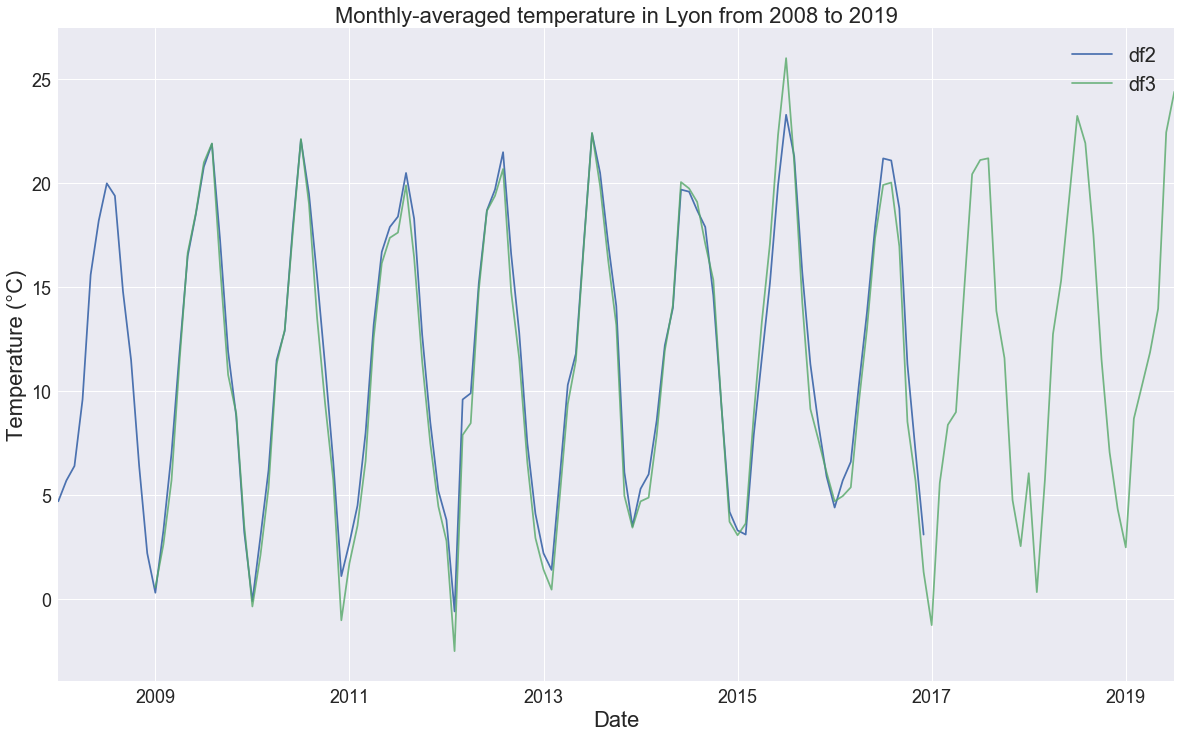

In [27]:
start = '2008'
end = '2019'
ax = df2.temp[start:end].plot(figsize=fs, label='df2');
df3[start:end].temp.plot(ax=ax, figsize=fs, alpha=0.8, label='df3');
ax.set_xlabel('Date');
ax.set_ylabel('Temperature (°C)');
ax.set_title(f'Monthly-averaged temperature in Lyon from {start} to {end}');
ax.legend();

In [28]:
(df3.temp-df2.temp).mean()

-0.5757724281550506

In [29]:
(df3.temp-df2.temp).std()

0.9170733016776305

### Aggregate all data : 1743-2019

In [30]:
df1['year'] = df1.index.year
df1['month'] = [calendar.month_abbr[i] for i in df1.index.month.to_list()]
df1.drop('unc', axis='columns', inplace=True)
df1.head(2)

,temp,year,month
date,,,
1743-11-01,6.59685,1743,Nov
1743-12-01,NaN,1743,Dec


In [31]:
df2.head(2)

,temp,year,month
date,,,
1901-01-01,0.9,1901,Jan
1901-02-01,-1.5,1901,Feb


In [32]:
df3['year'] = df3.index.year
df3['month'] = [calendar.month_abbr[i] for i in df3.index.month.to_list()]
df3.head(2)

,temp,year,month
date,,,
2009-01-01,0.561290,2009,Jan
2009-02-01,2.628571,2009,Feb


In [33]:
df = pd.concat([df1[:'1900'], df2['1901':'2008'], df3['2009':]], axis='rows')

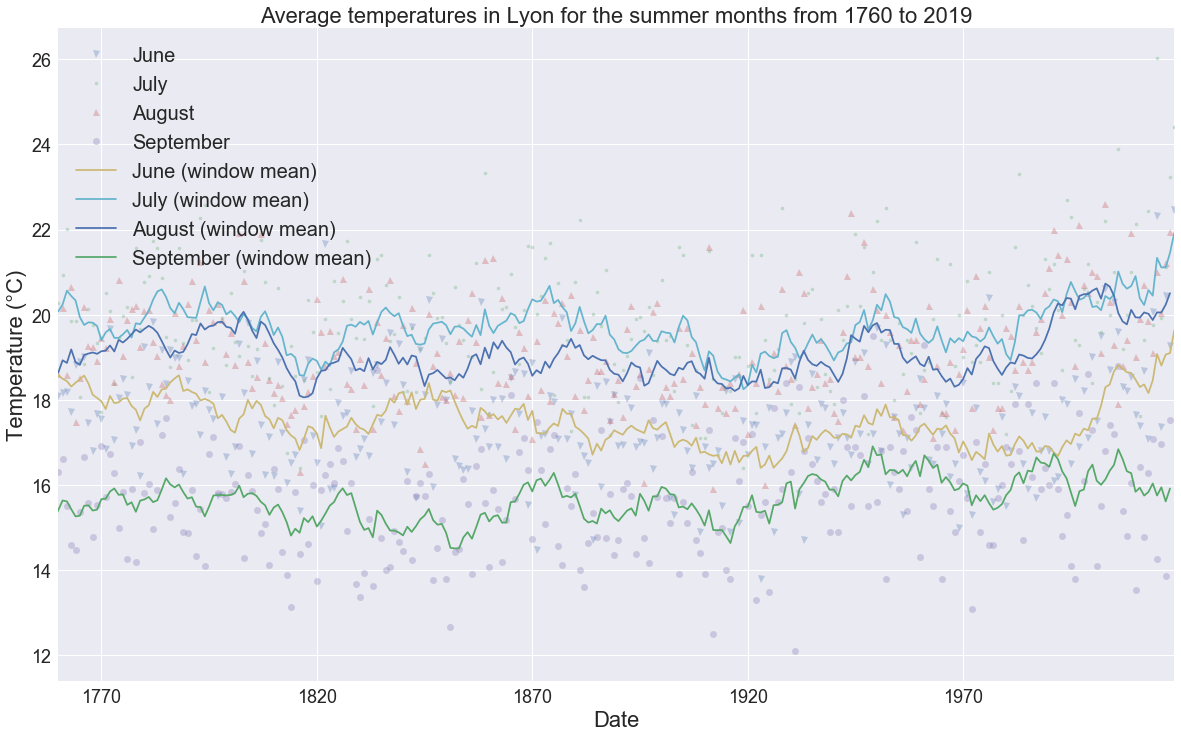

In [66]:
a = 0.3
hf = 4
ax = df[df.month == 'Jun'].temp.plot(figsize=fs, style='v', alpha=a, label='June');
df[df.month == 'Jul'].temp.plot(ax=ax, style='.', alpha=a, label='July');
df[df.month == 'Aug'].temp.plot(ax=ax, style='^', alpha=a, label='August');
df[df.month == 'Sep'].temp.plot(ax=ax, style='o', alpha=a, label='September');
df[df.month == 'Jun'].temp.ewm(halflife=hf).mean().dropna().plot(ax=ax, label='June (window mean)');
df[df.month == 'Jul'].temp.ewm(halflife=hf).mean().dropna().plot(ax=ax, label='July (window mean)');
df[df.month == 'Aug'].temp.ewm(halflife=hf).mean().dropna().plot(ax=ax, label='August (window mean)');
df[df.month == 'Sep'].temp.ewm(halflife=hf).mean().dropna().plot(ax=ax, label='September (window mean)');
ax.set_xlabel('Date');
ax.set_ylabel('Temperature (°C)');
ax.legend();
ax.set_xlim('1760', '2019')
ax.set_title('Average temperatures in Lyon for the summer months from 1760 to 2019');

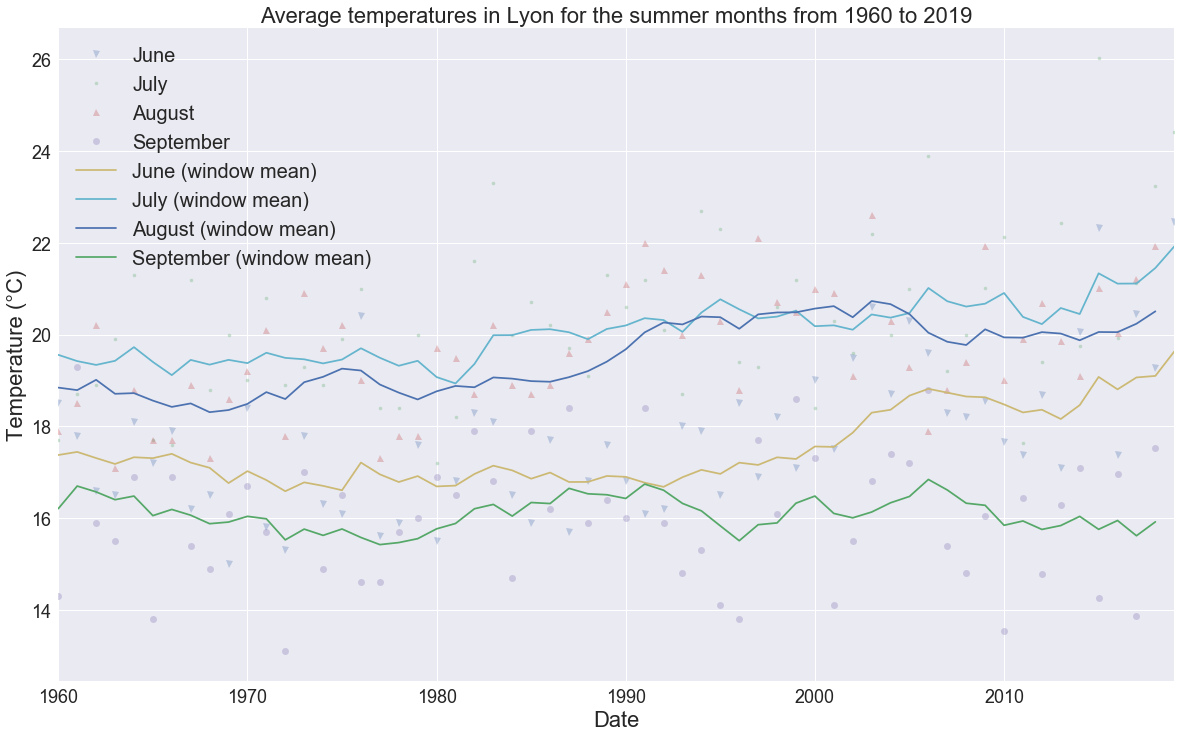

In [64]:
start = '1960'
end = '2019'
a = 0.3
hf = 4
ax = df[df.month == 'Jun'][start:end].temp.plot(figsize=fs, style='v', alpha=a, label='June');
df[df.month == 'Jul'][start:end].temp.plot(ax=ax, style='.', alpha=a, label='July');
df[df.month == 'Aug'][start:end].temp.plot(ax=ax, style='^', alpha=a, label='August');
df[df.month == 'Sep'][start:end].temp.plot(ax=ax, style='o', alpha=a, label='September');
df[df.month == 'Jun'].temp.ewm(halflife=hf).mean().dropna()[start:end].plot(ax=ax, label='June (window mean)');
df[df.month == 'Jul'].temp.ewm(halflife=hf).mean().dropna()[start:end].plot(ax=ax, label='July (window mean)');
df[df.month == 'Aug'].temp.ewm(halflife=hf).mean().dropna()[start:end].plot(ax=ax, label='August (window mean)');
df[df.month == 'Sep'].temp.ewm(halflife=hf).mean().dropna()[start:end].plot(ax=ax, label='September (window mean)');
ax.set_xlabel('Date');
ax.set_ylabel('Temperature (°C)');
ax.legend();
ax.set_title(f'Average temperatures in Lyon for the summer months from {start} to {end}');

## Temperature data analysis

We are going to look at the recent regional warming by looking at the yearly-averaged temperature.

### Regional warming since 1960 °C - June and July

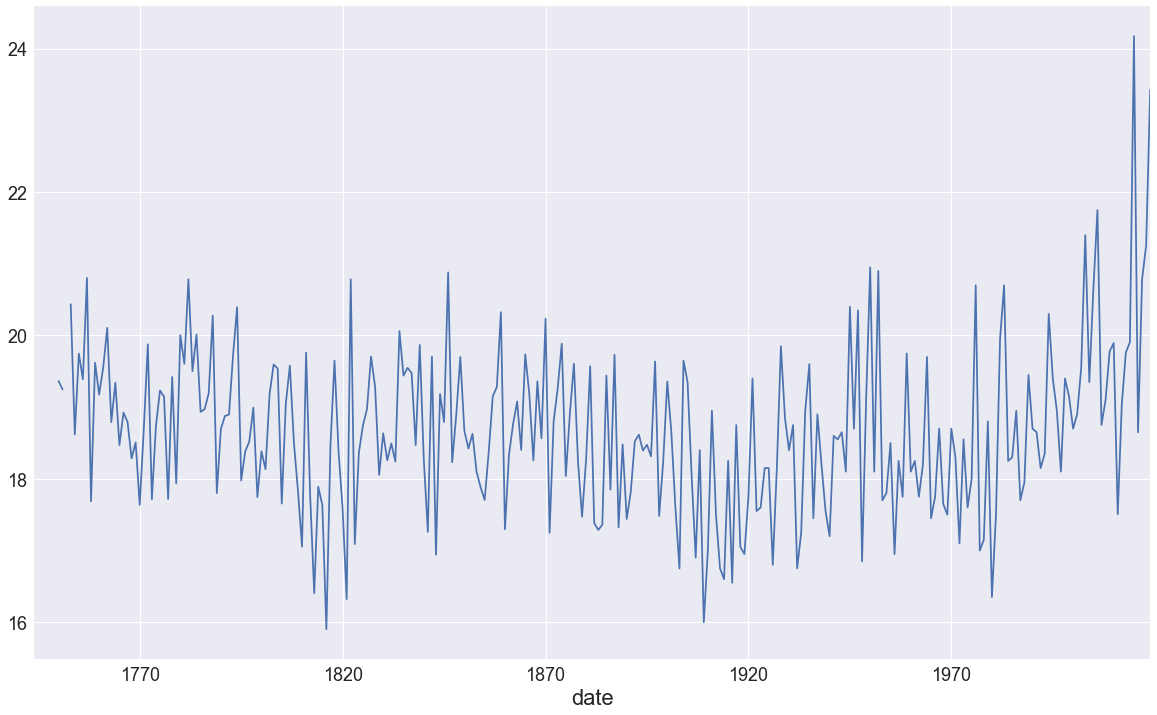

In [69]:
df_summer = df[df.month.isin(['Jun', 'Jul'])].resample('Y').mean().temp
df_summer.plot(figsize=fs);

In [70]:
t_summer = df_summer['1850':'1950'].mean()
t_summer

18.35080560513143

In [71]:
df_summer = df_summer.to_frame()

In [72]:
df_summer['anomaly'] = df_summer - t_summer

In [73]:
anomaly = df_summer.anomaly.copy(deep=True).to_frame()
anomaly['label'] = anomaly.index.year.astype(str)
anomaly.loc[anomaly['label'].str[-1] != '0', 'label'] = ''

In [74]:
anomaly.head()

,anomaly,label
date,,
1744-12-31,-0.440956,
1745-12-31,NaN,
1746-12-31,NaN,
1747-12-31,NaN,
1748-12-31,NaN,


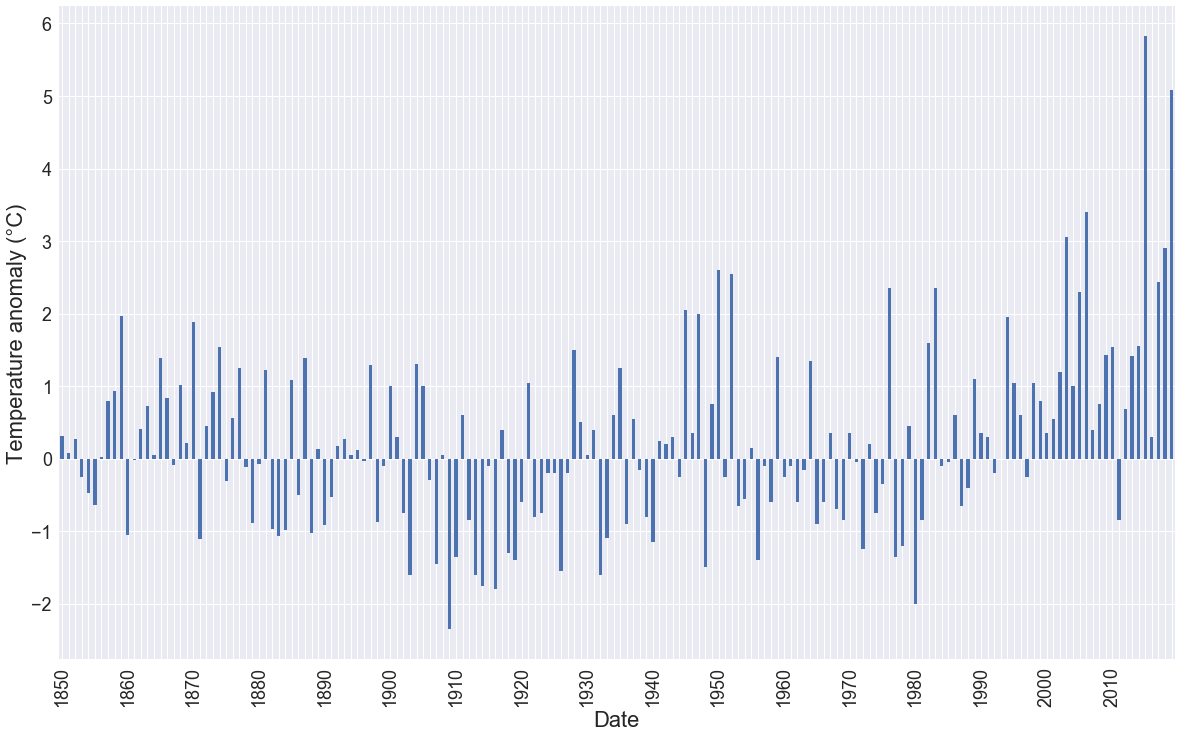

In [78]:
ax = anomaly['1850':].plot.bar(x='label', y='anomaly', figsize=fs, legend=False, rot=90);
ax.set_xlabel('Date');
ax.set_ylabel('Temperature anomaly (°C)');

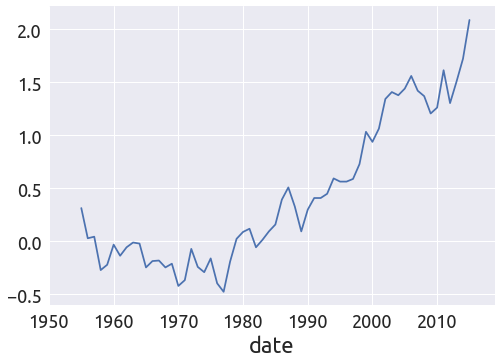

In [162]:
anomaly[start:].anomaly.rolling(10, center=True).mean().plot(x=anomaly[start:].index.year);

In [168]:
rw = anomaly.anomaly.rolling(10, center=True).mean().to_frame('window')

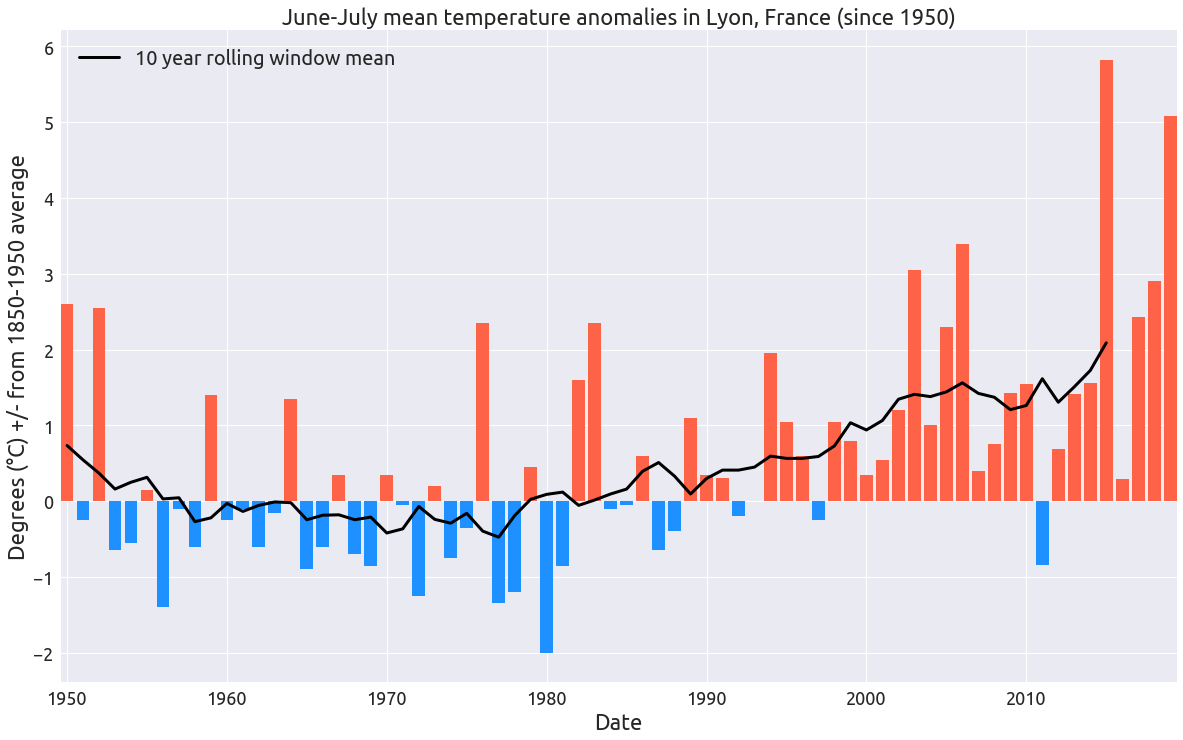

In [196]:
start = '1950'
fig, ax = plt.subplots(figsize=fs)
mask = (anomaly[start:].anomaly > 0)
colors = np.array(['dodgerblue'] * len(anomaly[start:]))
colors[mask.values] = 'tomato'
plt.bar(anomaly[start:].index.year, anomaly[start:].anomaly, color=colors)
plt.plot(rw[start:].index.year.tolist(), rw[start:].window.values, 'k', linewidth=3, label='10 year rolling window mean')
ax.legend()
ax.set_xlabel('Date');
ax.set_ylabel('Degrees (°C) +/- from 1850-1950 average');
plt.autoscale(enable=True, axis='x', tight=True)
ax.set_title('June-July mean temperature anomalies in Lyon, France (since 1950)');